In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA, PCA
from tqdm import tqdm
from utls import read_file, comb_dataset, min_max_scale

In [ ]:
d, l = read_file('Datasets/cluster_3/15_onesinit_2design_h1=0.6')
d1 = d[0:1601]
d2 = d[1601:]
l = torch.arange(-2.3, 1.601, 0.001)
d2 = torch.flip(d2, dims=[0])
d = torch.cat((d2, d1), dim=0)

In [3]:
ds = comb_dataset(d, l)
batch_size = 256
dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

In [ ]:
from models.ctvae_res import VAE
from models.vae import vae_loss
model = VAE(1, d.shape[1], 16).cuda('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_history = []
epochs = 1000

In [ ]:
with tqdm(total=epochs*len(dataloader)) as pbar:
    for epoch in range(epochs):
        train_loss = 0
        for i, (x, c) in enumerate(dataloader):
            x = x.cuda('cuda:0')
            c = c.cuda('cuda:0')
            x_recon, mu, logvar = model(x)
            loss = vae_loss(x, x_recon, mu, logvar, beta=3)
            optimizer.zero_grad()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({"Epoch": epoch + 1, "Loss": f"{train_loss / ((i + 1) * batch_size):.4f}"})
        avg_loss = train_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)

  0%|          | 0/16000 [00:00<?, ?it/s]/tmp/ipykernel_1573879/2427869634.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  train_loss += loss.item()
100%|██████████| 16000/16000 [05:48<00:00, 45.87it/s, Epoch=1000, Loss=24.5912]


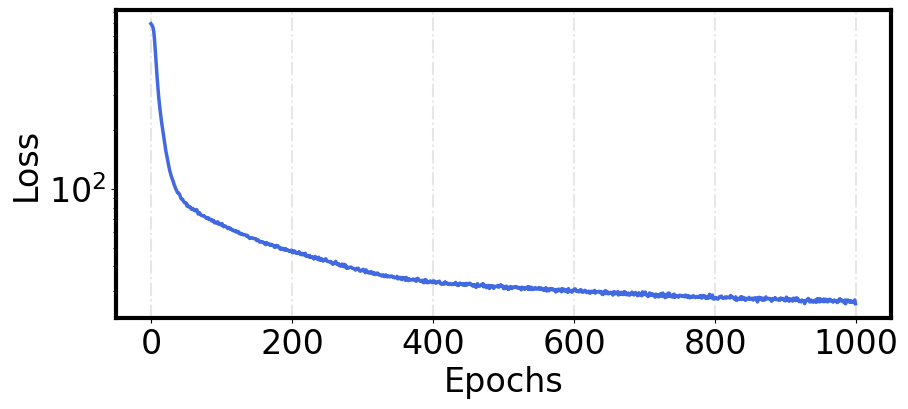

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 4))
plt.plot(loss_history, label='Training Loss', color='royalblue', linewidth=2.5)
plt.xlabel('Epochs', fontsize=24)
plt.ylabel('Loss', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.yscale('log')
# plt.xscale('log')
plt.grid(axis='x', linestyle='-.', alpha=0.3, linewidth=1.5)
ax = plt.gca()
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)
ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)

# plt.savefig('ising_loss.svg',bbox_inches='tight')
plt.show()

In [7]:
model.eval()
model.to('cpu')
mu, logvar = model.encode(d)
z = model.reparameterizer(mu, logvar)
z = z.detach().numpy()
from sklearn.preprocessing import StandardScaler
z_scaled = StandardScaler().fit_transform(z)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_latent(tensor_set, labels_set, 
                title='Latent Space',
                xlabel='z1',
                ylabel='z2',
                cbars="J'/J",
                colors='plasma',
                grid=True,
                alpha=1.0, s=60, marker='D',
                save_path=None,
                font_size1=16, font_size2=16, cbar_size=16,
                figsize=(10, 8)):

    if torch.is_tensor(tensor_set):
        tensor_set = tensor_set.detach().cpu().numpy()
    if torch.is_tensor(labels_set):
        labels_set = labels_set.detach().cpu().numpy()

    unique_labels = np.unique(labels_set)
    num_labels = len(unique_labels)

    fig, ax = plt.subplots(figsize=figsize)

    palette = sns.color_palette(colors, num_labels)

    sns.scatterplot(
        x=tensor_set[:, 0],
        y=tensor_set[:, 1],
        hue=labels_set,
        palette=palette,
        alpha=alpha,
        legend=False,
        s=s,
        marker=marker,
        ax=ax,
        edgecolor='w',  # 设置边框颜色
        linewidth=0.25  # 设置边框线宽
    )

    ax.set_title(title, fontsize=font_size1)
    ax.set_xlabel(xlabel, fontsize=font_size2)
    ax.set_ylabel(ylabel, fontsize=font_size2)

    # 设置刻度样式：外翻 + 黑色 + 粗线
    ax.tick_params(axis='both', direction='in', length=4, width=1.5, colors='black', labelsize=font_size2)

    # 设置色条
    norm = plt.Normalize(np.min(labels_set), np.max(labels_set))
    sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
    sm.set_array([])

    if cbars:
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label(cbars, fontsize=cbar_size)
        cbar.ax.tick_params(labelsize=cbar_size)
        # 自动判断刻度间隔
        ticks = np.linspace(np.min(labels_set), np.max(labels_set), num=6)
        cbar.set_ticks(np.round(ticks, 3))

    # 网格控制
    if grid:
        ax.grid(grid, linewidth=0.5, color='gray', linestyle='-.')
    else:
        ax.grid(False)

    # 坐标轴边框线加粗
    for spine in ax.spines.values():
        spine.set_linewidth(3.0)
        # 隐藏 x 和 y 的刻度和刻度标签
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

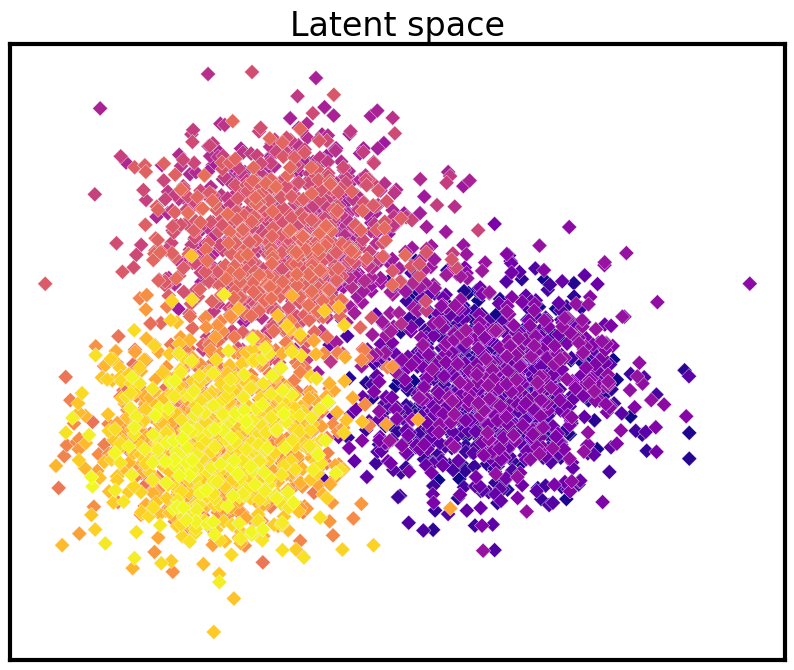

In [ ]:
plot_latent(z_pca, l, grid=False, 
            xlabel = None, 
            ylabel = None, None, 
            font_size1=24, font_size2=24,
             cbar_size=24, 
            cbars=None,
            colors='plasma', s=60,
            # save_path = 'ising_pca.pdf'
            )

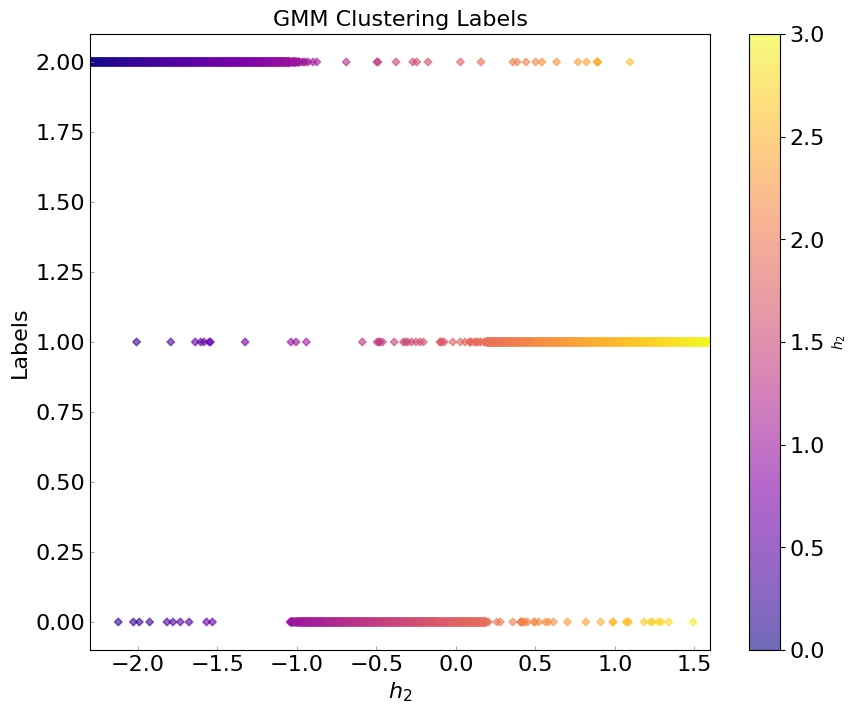

In [12]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(z_pca)
labels = gmm.fit_predict(z_pca)
probs = gmm.predict_proba(z_pca)
from plot import plot_dim_1
plot_dim_1(labels, l, title='GMM Clustering Labels', ylabel='Labels', xlabel = r'$h_2$')